## Forecasting COVID-19 incidence

The goal is to forecasting the incidence of COVID-19 cases. Before forecasting we will begin by investigating the relationship between demographic factors and COVID-19 incidence.

### Strategy

  1. Inspect correlations between demographic factors and COVID-19 prevelance

  2. Implement LSTM model for COVID-19 forecasting and evaluate on state and county-level data

  3. Visualize the performance of model trained on county-level data

In [1]:
import plotly.figure_factory as ff
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import json
from scipy.stats import pearsonr
import data_cleaners as dc

In [2]:
# Load and process US covid count data (get total counts at 3/23/22)
def get_covid_data():
    cub = dc.CUBData()
    covid = cub.us_cases
    covid["key"] = [
        "{}_{}".format(state, county)
        for county, state in zip(covid["Admin2"], covid["Province_State"])
    ]
    s = covid.filter(like="/")

    total_counts = s.iloc[:, -1]
    covids = covid[["key", "Province_State"]]
    covids["total_counts"] = total_counts
    return covids

In [3]:
covids = get_covid_data()
covids

,key,Province_State,total_counts
0,Alabama_Autauga,Alabama,15596
1,Alabama_Baldwin,Alabama,55358
2,Alabama_Barbour,Alabama,5475
3,Alabama_Bibb,Alabama,6413
4,Alabama_Blount,Alabama,14890
...,...,...,...
3337,Wyoming_Teton,Wyoming,9887
3338,Wyoming_Uinta,Wyoming,5633
3339,Wyoming_Unassigned,Wyoming,0
3340,Wyoming_Washakie,Wyoming,2349


In [4]:
# Get country level data by state
counties = pd.read_csv("assets/County_Demo_1012.csv")
counties

,s_county,combined_key,fips,population,white_pct,black_pct,hispanic_pct,nonwhite_pct,foreignborn_pct,female_pct,...,adult_smoking,adult_obesity,percent_uninsured,social_association_rate,air_quality_avg_pm,percent_diabetic,percent_insufficient_sleep,percent_uninsured_adults,percent_uninsured_children,icubeds
0,Alabama_Autauga,"Autauga, Alabama, US",1001,55869,75.683479,18.370907,2.572254,24.316519,1.838362,51.176224,...,19.124659,37.500000,8.500966,12.631731,11.7,14.2,35.905407,10.961103,2.476191,6
1,Alabama_Baldwin,"Baldwin, Alabama, US",1003,223234,83.178787,9.225603,4.366698,16.821213,3.269510,51.194927,...,16.795485,31.000000,10.699288,10.692213,10.3,11.3,33.305866,13.570311,3.238027,51
2,Alabama_Barbour,"Barbour, Alabama, US",1005,24686,45.885624,47.888329,4.309762,54.114376,2.859397,46.498085,...,21.540878,44.299999,12.513197,8.472944,11.5,18.0,38.563168,16.542240,2.901424,5
3,Alabama_Bibb,"Bibb, Alabama, US",1007,22394,74.765198,21.212122,2.223994,25.234804,1.351232,46.464645,...,19.916405,37.799999,9.680076,10.157664,11.2,14.9,38.148865,12.297319,2.619447,0
4,Alabama_Blount,"Blount, Alabama, US",1009,57826,87.657700,1.557951,8.727298,12.342299,4.271801,50.485233,...,19.652159,34.400002,12.114004,9.011507,11.7,14.3,35.945011,15.564604,3.430136,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,Wyoming_Sublette,"Sublette, Wyoming, US",56035,9831,91.646729,0.000000,7.814992,8.353270,2.053429,46.949760,...,14.415014,25.799999,13.645039,8.189170,5.1,7.9,29.000738,14.785214,10.971660,0
2777,Wyoming_Sweetwater,"Sweetwater, Wyoming, US",56037,42343,79.815674,0.865839,15.859591,20.184326,5.509685,47.824242,...,17.566944,30.200001,12.750853,9.962640,5.1,8.4,31.170904,15.270087,7.153332,10
2778,Wyoming_Teton,"Teton, Wyoming, US",56039,23464,81.200546,0.614419,15.174822,18.799452,11.475047,48.097069,...,14.137266,13.600000,14.979313,18.110474,4.9,4.2,26.551743,16.043394,11.421708,6
2779,Wyoming_Uinta,"Uinta, Wyoming, US",56041,20226,87.718376,0.186665,8.959939,12.281626,3.986981,49.327526,...,18.180586,31.799999,12.568976,5.295335,5.9,9.3,31.090485,15.073191,7.786820,6


In [5]:
# Merge data
merged_covid = covids.merge(counties, left_on="key", right_on="s_county")
merged_covid

,key,Province_State,total_counts,s_county,combined_key,fips,population,white_pct,black_pct,hispanic_pct,...,adult_smoking,adult_obesity,percent_uninsured,social_association_rate,air_quality_avg_pm,percent_diabetic,percent_insufficient_sleep,percent_uninsured_adults,percent_uninsured_children,icubeds
0,Alabama_Autauga,Alabama,15596,Alabama_Autauga,"Autauga, Alabama, US",1001,55869,75.683479,18.370907,2.572254,...,19.124659,37.500000,8.500966,12.631731,11.7,14.2,35.905407,10.961103,2.476191,6
1,Alabama_Baldwin,Alabama,55358,Alabama_Baldwin,"Baldwin, Alabama, US",1003,223234,83.178787,9.225603,4.366698,...,16.795485,31.000000,10.699288,10.692213,10.3,11.3,33.305866,13.570311,3.238027,51
2,Alabama_Barbour,Alabama,5475,Alabama_Barbour,"Barbour, Alabama, US",1005,24686,45.885624,47.888329,4.309762,...,21.540878,44.299999,12.513197,8.472944,11.5,18.0,38.563168,16.542240,2.901424,5
3,Alabama_Bibb,Alabama,6413,Alabama_Bibb,"Bibb, Alabama, US",1007,22394,74.765198,21.212122,2.223994,...,19.916405,37.799999,9.680076,10.157664,11.2,14.9,38.148865,12.297319,2.619447,0
4,Alabama_Blount,Alabama,14890,Alabama_Blount,"Blount, Alabama, US",1009,57826,87.657700,1.557951,8.727298,...,19.652159,34.400002,12.114004,9.011507,11.7,14.3,35.945011,15.564604,3.430136,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,Wyoming_Sublette,Wyoming,1924,Wyoming_Sublette,"Sublette, Wyoming, US",56035,9831,91.646729,0.000000,7.814992,...,14.415014,25.799999,13.645039,8.189170,5.1,7.9,29.000738,14.785214,10.971660,0
2730,Wyoming_Sweetwater,Wyoming,11045,Wyoming_Sweetwater,"Sweetwater, Wyoming, US",56037,42343,79.815674,0.865839,15.859591,...,17.566944,30.200001,12.750853,9.962640,5.1,8.4,31.170904,15.270087,7.153332,10
2731,Wyoming_Teton,Wyoming,9887,Wyoming_Teton,"Teton, Wyoming, US",56039,23464,81.200546,0.614419,15.174822,...,14.137266,13.600000,14.979313,18.110474,4.9,4.2,26.551743,16.043394,11.421708,6
2732,Wyoming_Uinta,Wyoming,5633,Wyoming_Uinta,"Uinta, Wyoming, US",56041,20226,87.718376,0.186665,8.959939,...,18.180586,31.799999,12.568976,5.295335,5.9,9.3,31.090485,15.073191,7.786820,6


## Factors that correleate with COVID-19

Now we will look at how various factors in the county dataset are correlated the proportion of the population with COVID-19 over time.

In [6]:
# Start by finding porportion of cases in population
merged_covid["percent_covid"] = (
    merged_covid["total_counts"] / merged_covid["population"] * 100
).round(2)
merged_covid[["combined_key", "percent_covid"]]

,combined_key,percent_covid
0,"Autauga, Alabama, US",27.92
1,"Baldwin, Alabama, US",24.80
2,"Barbour, Alabama, US",22.18
3,"Bibb, Alabama, US",28.64
4,"Blount, Alabama, US",25.75
...,...,...
2729,"Sublette, Wyoming, US",19.57
2730,"Sweetwater, Wyoming, US",26.08
2731,"Teton, Wyoming, US",42.14
2732,"Uinta, Wyoming, US",27.85


In [7]:
# Factors of interest
factors = [
    "white_pct",
    "black_pct",
    "hispanic_pct",
    "nonwhite_pct",
    "foreignborn_pct",
    "female_pct",
    "age29andunder_pct",
    "age65andolder_pct",
    "median_hh_inc",
    "clf_unemploy_pct",
    "lesshs_pct",
    "lesscollege_pct",
    "rural_pct",
    "popdensity",
    "housedensity",
    "km_from_equator",
    "poor_or_fair_health",
    "adult_smoking",
    "adult_obesity",
    "percent_uninsured",
    "social_association_rate",
    "air_quality_avg_pm",
    "percent_insufficient_sleep",
    "percent_uninsured_adults",
    "percent_uninsured_children",
]

In [8]:
def get_factors(col_of_interest):
    """
    Find correlation of each factor of interest with the population of individuals with COVID in each county.

    Returns a sorted dictionary of coeeficients and p-values.
    """

    to_return_dict = {}

    for factor in factors:
        coef, pval = pearsonr(merged_covid[col_of_interest], merged_covid[factor])
        to_return_dict[factor] = (coef, pval)

    to_return_dict = dict(
        sorted(to_return_dict.items(), key=lambda x: x[1][0], reverse=True)
    )

    return to_return_dict


result_dict = get_factors("percent_covid")
result_dict

{'adult_smoking': (0.34838706001239794, 7.535235972784684e-79),
 'poor_or_fair_health': (0.31978622189169326, 4.774972397620813e-66),
 'adult_obesity': (0.2668383711296369, 8.617140013510052e-46),
 'lesshs_pct': (0.2540874425266933, 1.527223582556921e-41),
 'lesscollege_pct': (0.24034900339650875, 3.1630882076599463e-37),
 'percent_insufficient_sleep': (0.2068207047514407, 8.50885628883116e-28),
 'age29andunder_pct': (0.18907873143504145, 2.0203216300478007e-23),
 'air_quality_avg_pm': (0.17942513314722017, 3.2534090826263154e-21),
 'clf_unemploy_pct': (0.13025777274649822, 8.092146504841438e-12),
 'nonwhite_pct': (0.07065666892206944, 0.00021781522154906504),
 'social_association_rate': (0.04809459217319443, 0.011901233720344214),
 'hispanic_pct': (0.04612901598643017, 0.015858337593931834),
 'percent_uninsured_adults': (0.030434116622028527, 0.11161639116940617),
 'black_pct': (0.025150349168389957, 0.18862432469350968),
 'popdensity': (0.007633628309730113, 0.6899168647501331),
 'pe

In [9]:
# Extracting keys, values, and colors from the dictionary
keys = list(result_dict.keys())
values = [item[0] for item in result_dict.values()]
colors = [item[1] for item in result_dict.values()]

# Create a bar plot
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=keys,
        x=values,
        orientation="h",
        marker=dict(
            color=colors,
            colorscale="Viridis",  # You can choose other color scales
            cmin=min(colors),
            cmax=max(colors),
            colorbar=dict(title="P-Value"),
        ),
    )
)

# Add labels and title
fig.update_layout(
    title="Factors that correleate with COVID",
    xaxis_title="Coefficient Value",
    yaxis_title="Features",
    height=600,  # Set the height of the figure
    width=800,  # Set the width of the figure
)

# Show the plot
fig.show()

Smoking is the factor most positvely corrleated with covid cases, followed by poor health and obesity. Conversely, median household income negatively correlates with covid. 

We can plot the ratio of cases in comparision to smokers:

In [10]:
# Clean up the data

merged_covid["total_smoking"] = (merged_covid["adult_smoking"] / 100) * merged_covid[
    "population"
]

cols = [
    "Province_State",
    "population",
    "total_smoking",
    "total_counts",
]
df_states = merged_covid[cols].groupby("Province_State", as_index=False).sum()

# percents
df_states["percent_smoking"] = (
    df_states["total_smoking"] / df_states["population"] * 100
).round(4)
df_states["percent_covid"] = (
    df_states["total_counts"] / df_states["population"] * 100
).round(4)

# codes
codes = pd.read_json("assets/states.json")
code_dict = codes[["State", "Code"]].set_index("State").to_dict()["Code"]
df_states["code"] = df_states["Province_State"].map(code_dict)

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Percent Covid Cases", "Percent Smoking"],
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]],
)

fig.add_trace(
    go.Choropleth(
        locations=df_states["code"],
        z=df_states["percent_covid"].astype(float),
        locationmode="USA-states",
        colorscale="Blues",
        colorbar=dict(x=0.46),
        marker=dict(opacity=0.75, line_width=0.5),
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Choropleth(
        locations=df_states["code"],
        z=df_states["percent_smoking"].astype(float),
        locationmode="USA-states",
        colorscale="Blues",
        colorbar=dict(x=1.02),
        marker=dict(opacity=0.75, line_width=0.5),
    ),
    row=1,
    col=2,
)

fig.update_geos(
    scope="usa",  # limite map scope to USA
)


fig.show()

## LSTM model for COVID-19 forecasting

We will implement elements of the model explained in the paper: [A spatiotemporal machine learning approach to forecasting
COVID-19 incidence at the county level in the United States](https://arxiv.org/pdf/2109.12094.pdf). Unlike the paper we will not be implementing an ensemble but only one model.

In [11]:
# Import needed functions and set constants
import find_best_hyperparameters as fbh

STATE = "Wisconsin"
COUNTY = "Milwaukee"
BURNIN_WEEKS = 14  # after INITIAL_DATE
NUM_BIWEEKLY_INTERVALS = 20  # after the burnin period

In [12]:
# Run LSTM model and get results
err_results_df, final_results_state, final_results_county = fbh.eval_results(
    BURNIN_WEEKS,
    NUM_BIWEEKLY_INTERVALS,
    STATE,
    COUNTY,
    dc.TEMPORAL_LAG,
    dc.FORECAST_HORIZON,
)

Training for 20 intervals...
Training interval 1 for 2020-07-12 with 360 train samples (state)
Training interval 1 for 2020-07-12 with 5 train samples (county)
Training interval 6 for 2020-09-20 with 1080 train samples (state)
Training interval 6 for 2020-09-20 with 15 train samples (county)
Training interval 11 for 2020-11-29 with 1800 train samples (state)
Training interval 11 for 2020-11-29 with 25 train samples (county)
Training interval 16 for 2021-02-07 with 2520 train samples (state)
Training interval 16 for 2021-02-07 with 35 train samples (county)
Training interval 20 for 2021-04-04 with 3096 train samples (state)
Training interval 20 for 2021-04-04 with 43 train samples (county)


In [30]:
dates = err_results_df["forecast_dates"].to_list()  # Grab dates for later
final_results_state[0]  # View final results (quantile predictions) for 1 interval

,GEOID,q_25_pred,q_100_pred,q_250_pred,q_500_pred,q_750_pred,q_900_pred,q_975_pred,q_25_err,q_100_err,...,q_500_pred_cases,q_750_pred_transform,q_750_pred_cases,q_900_pred_transform,q_900_pred_cases,q_975_pred_transform,q_975_pred_cases,y_lbl_transform,y_label_transformed,y_q500_err
0,55001,0.635589,1.002670,1.288619,1.791573,2.114679,2.272347,2.594077,1.198749,0.831668,...,10.044756,7.286922,14.642341,8.702142,17.486085,12.384233,24.884877,5.260988,10.571429,3.955244
1,55003,-0.078284,0.048682,0.202558,0.476518,0.863776,1.178725,1.442916,1.469239,1.342274,...,0.953350,1.372101,2.142810,2.250227,3.514179,3.233022,5.049010,3.018688,4.714285,2.046650
2,55005,0.203755,0.447571,0.653695,0.957949,1.307522,1.551007,1.877635,1.395262,1.151445,...,7.265336,2.697001,12.198268,3.716218,16.808084,5.538025,25.047933,3.948162,17.857142,18.734664
3,55007,-0.086343,0.029824,0.184011,0.468769,0.861608,1.180477,1.432570,1.657311,1.541144,...,0.896619,1.366963,2.049488,2.255926,3.382310,3.189453,4.781946,3.811302,5.714285,6.103381
4,55009,0.876518,1.399229,1.724225,2.142611,2.422347,2.560186,2.970703,1.445221,0.922510,...,196.592041,10.272285,268.484662,11.938229,312.027093,18.505630,483.677942,9.193387,240.285718,68.407959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,55133,0.750825,1.201509,1.508737,1.934113,2.229972,2.376857,2.759756,1.638170,1.187485,...,236.997347,8.299605,332.378416,9.770997,391.303995,14.795986,592.542245,9.902526,396.571406,285.002653
68,55135,0.753277,1.208219,1.513595,1.934927,2.232889,2.381529,2.769037,1.489445,1.034503,...,30.355177,8.326774,42.670553,9.821432,50.329928,14.943266,76.576765,8.418940,43.142856,12.644823
69,55137,0.544115,0.897831,1.168038,1.583086,1.904514,2.080289,2.422602,1.158398,0.804682,...,9.362602,5.716145,13.829069,7.006782,16.951507,10.275158,24.858691,4.487720,10.857142,1.362602
70,55139,0.692932,1.154079,1.449917,1.768027,2.063005,2.233786,2.654485,0.892494,0.431348,...,82.807474,6.869584,117.065269,8.335141,142.039969,13.217669,225.243614,3.881372,66.142856,9.807474


In [27]:
# Final reults for a state

preds_new_cases = []
actual_new_cases = []
pred_25 = []
pred_975 = []
state_GEOID = 55079  # Milwaukee County, Winsconsin

for i in range(len(final_results_state)):
    df = final_results_state[i]
    preds_new_cases.append(df[df["GEOID"] == state_GEOID]["q_500_pred_cases"].values[0])
    pred_25.append(
        df[df["GEOID"] == state_GEOID]["q_25_pred_cases"].values[0]
    )  # Lower quantile (2.5th quantile)
    pred_975.append(
        df[df["GEOID"] == state_GEOID]["q_975_pred_cases"].values[0]
    )  # Upper quantile (97.5th quantile)
    actual_new_cases.append(df[df["GEOID"] == state_GEOID]["y_delta_cases"].values[0])

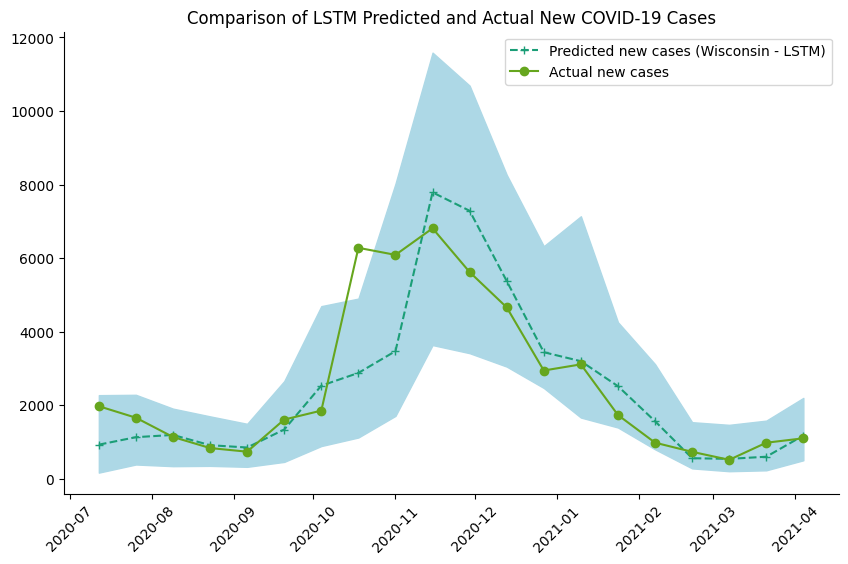

In [33]:
# Plot showing the predicted (50th quantile), actual number of cases, and the range
# between the 2.5th quantile and the 97.5th quantile for the county with data from the state level LSTM model.

import matplotlib.pyplot as plt

# YOUR CODE HERE
plt.figure(figsize=(10, 6))

plt.plot(
    dates,
    preds_new_cases,
    color="#1b9e77",
    marker="+",
    linestyle="dashed",
    label="Predicted new cases (Wisconsin - LSTM)",
)

plt.fill_between(dates, pred_25, pred_975, color="lightblue")

plt.plot(
    dates,
    actual_new_cases,
    color="#66a61e",
    marker="o",
    # linestyle = 'dashed',
    label="Actual new cases",
)

plt.xticks(rotation=45)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.title("Comparison of LSTM Predicted and Actual New COVID-19 Cases")
plt.legend()

plt.show()

The prediction intereval is widest around November 2020.